# Classification of trapped particles
Using forward scattering information.

In [1]:
import numpy as np
import os
from scipy import *
import pandas as pd
from matplotlib.pyplot import *
from sklearn import *
from pickle import *
#* is used to import all from that library 

# Load the time domain data 

In [4]:
def load_data(npoints, folder_path = "D:data OT//", nsegments=600):
    
    #path to the folder where data is stored
    #to find all the files required 
    

    #list the paths ending in .TDdat
    #to use only the files .TDdat, for files in that directory that end with .TDdat, where f are the files.TDdat
    path_files_TD = [folder_path+f for f in os.listdir(folder_path) if f.endswith('.dat')]

    #store the info for each file
    target = [] #type of target
    x_data = [] #xdata
    y_data = [] #ydata
    sum_data = [] #intensity data

    #read data
    #for each .dat file
    for i in range(0,len(path_files_TD)):

        #for a given path, all directory for each file will be printed
        current_path = path_files_TD[i]
        
        #read type
    
        #load data-read csv file
        #skiprows=2 to skip the text in .dat file 
        #delimiter='/t' space between each column 
        current_df = pd.read_csv(current_path,skiprows=2,header=None,delimiter='\t')
        #current_df contains the four columns of the file, which correspond to 
        #[0]-xdata, [1]-ydata, [2]-sum

        #Acquired 150 seconds(2 and half min) which correpond to approx 1500000 points, and so 
        #for 2 min(120 s) we can consider 1200000 points for each file
        xx = np.array(current_df[0])[0:nsegments*npoints]
        yy = np.array(current_df[1])[0:nsegments*npoints]
        sums = np.array(current_df[2])[0:nsegments*npoints]

        #cycle 
        #for each file [for i in range(0,len(path_files_TD))] divide the original file in sections that start in 
        #(i*npoints) and end in (i+1)*npoints), for each i in range(0, int(len(xx)/npoints), that is 59
        #x_data.append([xx[int(i*npoints):int((i+1)*npoints)] for i in range(0, int(len(xx)/npoints))])
        #y_data.append([yy[i*npoints:(i+1)*npoints] for i in range(0, int(len(yy)/npoints))])
        #sum_data.append([sums[i*npoints:(i+1)*npoints] for i in range(0, int(len(sums)/npoints))])
        #np.array split (split an array into multiple sub-arrays of equal or near-equal size)
        splits=int(len(xx)/npoints)
        x_data.append(np.array_split(np.array(xx),splits))
        y_data.append(np.array_split(np.array(yy),splits))
        sum_data.append(np.array_split(np.array(sums),splits))


        #print of the number of segments generated, considering the length divided by npoints (20000)
        print(current_path + " Read "+ str(int(len(xx)/npoints)) + " segments", end = '\r')

        #each file will be divided in 59 segments, which will be appended as targets     
        #read type
        for i in range(0,int(len(xx)/npoints)):
            #it will create 59 files of the same file and then in each one it will save 59 segments of the same original file
            #each part is stored in each 3umPMMA.dat file (59x)
            target.append(current_path.split('//')[2].split('.')[0][:-1])


    return target, x_data, y_data, sum_data


def data_classifier(x_data, y_data, sum_data, target):
    data_to_classify = []
    data_to_classify2 = []
    data_to_classify3 = []
    init = 1
    end = -1
    
    for i in range(0,len(x_data)):
        for j in range(0,len(x_data[i])):
            fft_x = np.fft.fft(x_data[i][j])[init:end]
            fft_y = np.fft.fft(y_data[i][j])[init:end]
            fft_sum = np.fft.fft(sum_data[i][j])[init:end]
            
            #fft_x = np.log10(np.abs(fft_x))
            #fft_y = np.log10(np.abs(fft_y))
            #fft_sum = np.log10(np.abs(fft_sum))
            
            data_to_classify.append(np.abs(fft_x))
            data_to_classify2.append(np.abs(fft_y))
            data_to_classify3.append(np.abs(fft_sum))
            

    data_to_classify=np.array(data_to_classify)
    data_to_classify2=np.array(data_to_classify2)
    data_to_classify3=np.array(data_to_classify3)

    dummy_labels = []
    labels = []
    unique_targets = np.unique(target)
    for i in range(0,len(target)):
        arr = np.zeros(len(unique_targets))
        labels.append(np.where(target[i]==unique_targets)[0][0])
        index = np.where(target[i]==unique_targets)[0][0]
        arr[index] = 1 
        dummy_labels.append(arr)

    labels=np.array(labels)
    dummy_labels = np.array(dummy_labels)
    
    return data_to_classify, data_to_classify2, data_to_classify3, labels, dummy_labels, unique_targets





def pca_data(data_to_classify, data_to_classify2, data_to_classify3, ncomp=3, use_only = False ):
        
    model = decomposition.PCA(n_components=ncomp)
    model.fit(data_to_classify)
    PCs1 = model.transform(data_to_classify)

    model.fit(data_to_classify2)
    PCs2 = model.transform(data_to_classify2)

    model.fit(data_to_classify3)
    PCs3 = model.transform(data_to_classify3)
    
    PCs = np.concatenate([PCs1[:,:],PCs2[:,:],PCs3[:,:]],axis=1)
    
    if use_only:
        PCs = np.concatenate([PCs1[:,:],PCs2[:,:]],axis=1)
        
    return PCs


def pca_data_new_model(data_to_classify, data_to_classify2, data_to_classify3, ncomp=3, use_only = False ):
        
    model1 = decomposition.PCA(n_components=ncomp)
    model1.fit(data_to_classify)
    PCs1 = model1.transform(data_to_classify)

    model2 = decomposition.PCA(n_components=ncomp)
    model2.fit(data_to_classify2)
    PCs2 = model2.transform(data_to_classify2)

    model3 = decomposition.PCA(n_components=ncomp)
    model3.fit(data_to_classify3)
    PCs3 = model3.transform(data_to_classify3)
    
    PCs = np.concatenate([PCs1[:,:],PCs2[:,:],PCs3[:,:]],axis=1)
    
    return PCs, [model1,model2,model3]


def pca_data_previous_model(data_to_classify, data_to_classify2, data_to_classify3, models, ncomp=3, use_only = False ):
    
    model1 = models[0]
    model2 = models[1]
    model3 = models[2]
    
    PCs1 = model1.transform(data_to_classify)

    PCs2 = model2.transform(data_to_classify2)

    PCs3 = model3.transform(data_to_classify3)
    
    PCs = np.concatenate([PCs1[:,:],PCs2[:,:],PCs3[:,:]],axis=1)
    
    return PCs



# Test a model

D:data OT - TT//test//water6.dat Read 1200 segmentstss

(21796, 498)
(21600, 498)
KNeighborsClassifier(n_neighbors=30)
Score test
0.6720183486238532
Score test
0.658256880733945
Score test
0.6688073394495413
Score test
0.6559633027522935
Score test
0.6536697247706422
Score test
0.6752293577981652
Score test
0.6729357798165138
Score test
0.6770642201834862
Score test
0.6651376146788991
Score test
0.6779816513761467


<IPython.core.display.Javascript object>


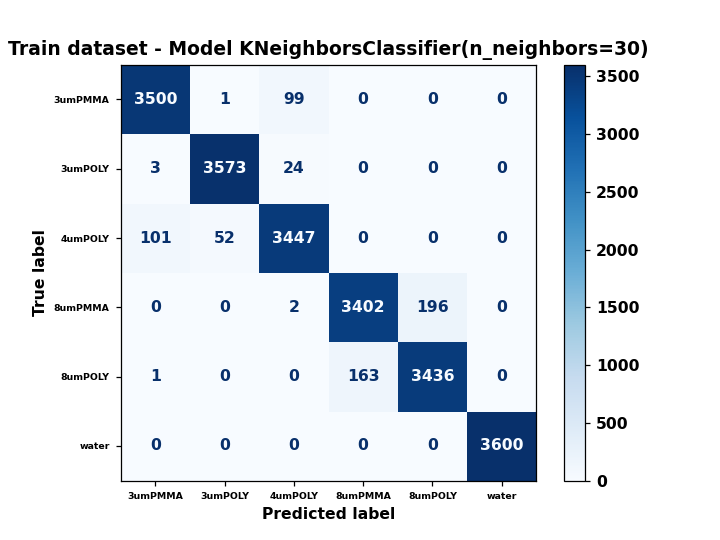

<IPython.core.display.Javascript object>


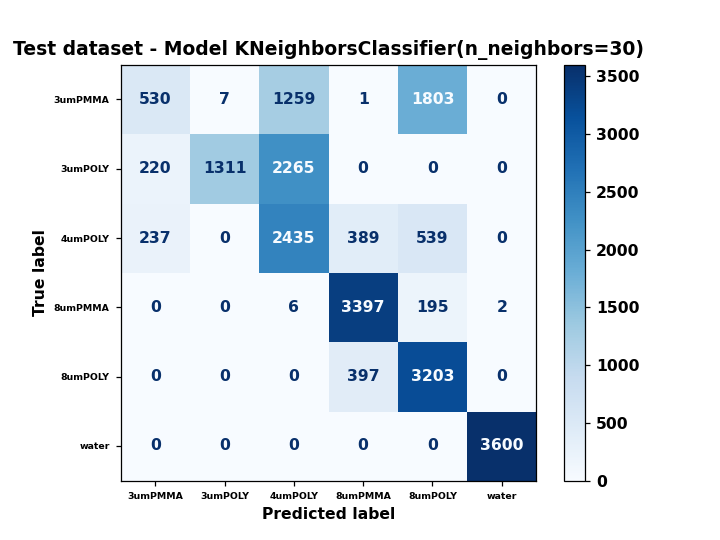

Model Accuracy -> 0.6677064220183486


In [6]:
%matplotlib notebook
def test_a_model(model, npoints, folder_train, folder_test, confusion_matrix = False, ncomp = 3,nsegments = 200, scaler = False , use_only = False):

    target_train, x_data_train, y_data_train, sum_data_train = load_data(npoints, folder_train, nsegments=nsegments)
    data_to_classify_train, data_to_classify2_train, data_to_classify3_train, labels_train, dummy_labels_train, unique_targets_train = data_classifier(x_data_train, 
                                                                                                   y_data_train, sum_data_train, target_train)
    


    PCs_train,pca_model = pca_data_new_model(data_to_classify_train, data_to_classify2_train, data_to_classify3_train, ncomp=ncomp, use_only = use_only)
    if scaler:
        scaler = preprocessing.StandardScaler()
        scaler.fit(PCs_train)
        PCs_train = scaler.transform(PCs_train)

    target_test, x_data_test, y_data_test, sum_data_test = load_data(npoints, folder_test, nsegments=nsegments)
    
    data_to_classify_test, data_to_classify2_test, data_to_classify3_test, labels_test, dummy_labels_test, unique_targets_test = data_classifier(x_data_test, 
                                                                                                   y_data_test, sum_data_test, target_test)
    

    PCs_test = pca_data_previous_model(data_to_classify_test, data_to_classify2_test, data_to_classify3_test, pca_model, ncomp=ncomp, use_only = use_only)
    
    if scaler:
        PCs_test = scaler.transform(PCs_test)
 

    print('\n')
    print(data_to_classify_test.shape)
    print(data_to_classify_train.shape)
    print(model)
    
    scores=[]
    for rs in range(0,10):
        ts=0.1



        X_train, X_test, y_train, y_test = model_selection.train_test_split(PCs_train, labels_train, test_size=ts, random_state=rs)
        trash1, X_test, trash2, y_test = model_selection.train_test_split(PCs_test, labels_test, test_size=ts, random_state=rs)

        model.fit(X_train,y_train)

        print('Score test')
        scr = model.score(X_test,y_test)
        print(model.score(X_test,y_test))
        scores.append(scr)
        
 
    if confusion_matrix:
        #Generate a confusion matrix
        labels_pred = model.predict(PCs_train)
        conf_mat = metrics.confusion_matrix(labels_train, labels_pred)#,normalize="true"
        #subplots()
        metrics.ConfusionMatrixDisplay(conf_mat,display_labels=unique_targets_test).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        ax = gca()
        ax.set_title("Train dataset - Model "+ str(model))
        
        #Generate a confusion matrix
        labels_pred = model.predict(PCs_test)
        conf_mat = metrics.confusion_matrix(labels_test, labels_pred)#,normalize="true"
        #subplots()
        metrics.ConfusionMatrixDisplay(conf_mat,display_labels=unique_targets_test).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        ax = gca()
        ax.set_title("Test dataset - Model "+ str(model))
        
        
    print("Model Accuracy -> " + str(np.mean(scores)))
    return scores, pca_model, model

model = ensemble.RandomForestClassifier(n_estimators=100,random_state=0)
model = tree.DecisionTreeClassifier()
model = neighbors.KNeighborsClassifier(30)
#model = svm.SVC(kernel="linear", C=0.25)
#model = neural_network.MLPClassifier(activation = 'tanh')
#model = linear_model.LogisticRegression()
#model = naive_bayes.GaussianNB()
folder_train = "D:data OT - TT//train//"
folder_test = "D:data OT - TT//test//"
npoints = 500
scores, pca_model, classifier_model = test_a_model(model, npoints, folder_train, folder_test, True, ncomp=2, nsegments = 1200, scaler = False, use_only = False)

In [48]:
filename1 = 'models/pca_model.sav'
dump(pca_model, open(filename1, 'wb'))

filename2 = 'models/classifier_model.sav'
dump(classifier_model, open(filename2, 'wb'))

filename3 = 'models/class_names.sav'
dump(unique_targets, open(filename3, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model_pca = load(open(filename1, 'rb'))
loaded_model_classifier = load(open(filename2, 'rb'))
loaded_unique_targets = load(open(filename3, 'rb'))
print(loaded_model_pca)
print(loaded_model_classifier)
print(loaded_unique_targets)

[PCA(n_components=2), PCA(n_components=2), PCA(n_components=2)]
KNeighborsClassifier(n_neighbors=30)
['3umPMMA' '3umPOLY' '4umPOLY' '8umPMMA' '8umPOLY' 'water']


In [33]:
def data_classifier_2(x_data, y_data, sum_data):
    data_to_classify = []
    data_to_classify2 = []
    data_to_classify3 = []
    init = 1
    end = -1
    
    fft_x = np.fft.fft(x_data)[init:end]
    fft_y = np.fft.fft(y_data)[init:end]
    fft_sum = np.fft.fft(sum_data)[init:end]
            
            #fft_x = np.log10(np.abs(fft_x))
            #fft_y = np.log10(np.abs(fft_y))
            #fft_sum = np.log10(np.abs(fft_sum))
            
    data_to_classify.append(np.abs(fft_x))
    data_to_classify2.append(np.abs(fft_y))
    data_to_classify3.append(np.abs(fft_sum))
            

    data_to_classify=np.array(data_to_classify)
    data_to_classify2=np.array(data_to_classify2)
    data_to_classify3=np.array(data_to_classify3)


    
    return data_to_classify, data_to_classify2, data_to_classify3

In [18]:
npoints = 500
folder_test = "D:data OT - TT//test//"
target_test, x_data_test, y_data_test, sum_data_test = load_data(npoints, folder_test, nsegments = 600)

In [47]:
def get_class(x_data,y_data,sum_data, pca_model2, classifier_model2):
    data_to_classify, data_to_classify2, data_to_classify3 = data_classifier_2(x_data, y_data, sum_data)
    PCs_test = pca_data_previous_model(data_to_classify, data_to_classify2, data_to_classify3, pca_model2, ncomp=2)
    labels_pred = model.predict(PCs_test)
    return labels_pred

unique_targets=np.unique(target_test)
i=5
j=0
x_data = x_data_test[i][j]
y_data = y_data_test[i][j]
sum_data = sum_data_test[i][j]
label_pred = get_class(x_data,y_data,sum_data,loaded_model_pca, loaded_model_classifier)
print(unique_targets[label_pred][0])
print(target_test[i*600+j])

3umPOLY
3umPOLY


In [36]:
len(target_test)

10996